# Classification: Now with Text (Word Embeddings) :D

Kaggle StumbleUpon Competition

https://www.kaggle.com/c/stumbleupon

** Competition **: 
1. Some web pages, such as news articles or seasonal recipes, are only relevant for a short period of time. Others continue to be important for a long time.
2. The goal is to identify pages which pages will be relevant for a short span of time, and which will be relevant for a long span on time and are thus considered "evergreen". 

** Evaluation **: Area under the curve (AUC) 


Import Python Modules 
=================

In [1]:
# quick hack to fix import path
# import sys; sys.path.append('/Users/julianalverio/code/conda/envs/sac/lib/python3.6/site-packages/')

# data manipulation
import pandas as pd
import numpy as np

# plots
%matplotlib inline
import random
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# dimensionality reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# text features
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# model evaluation
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir(os.path.join("..", "data"))

In [2]:
os.getcwd()

'/Users/geetickachauhan/Desktop/GSL Uruguay/machine_learning_aws/data'

# 1. Data Import

In [3]:
data = pd.read_table("stumbleupon/train.tsv", sep= "\t")

## Using Numerical Features (same as Week 1)

In [4]:
# Alchemy category, converting to one-hots
df = data['alchemy_category']   # 2K ? values
one_hots = pd.get_dummies(data['alchemy_category'])
df = one_hots
rename_dict = {'?': 'alchemy_cat_?'}
df = df.rename(columns=rename_dict)

# FrameTagRatio, leaving as continuous number
df_var = data['frameTagRatio']
df['frame_tag_ratio'] = df_var



# link word score, 0-100 gaussian, keeping continuous
df['link_word_score'] = data['linkwordscore']


# alchemy category score, with replacing missing values with random
df_var = data['alchemy_category_score']
df_var_temp = df_var.apply(lambda x: np.random.random() if x == '?' else float(x)).astype('float32')
df['alchemy_category_score'] = df_var_temp


# num word in url -- discrete 0-25 to custom binning from looking at the histogram
df_var = data['numwords_in_url']
bins = [0, 6, 8, 13, 25]
df_var_temp = pd.cut(x=df_var, bins=bins, right=True, labels=['num_words_url_bin_0', 'num_words_url_bin_1', 'num_words_url_bin_2', 'num_words_url_bin_3'])
dummies = pd.get_dummies(df_var_temp)
df = pd.concat([df, dummies], axis=1)


# parameterized_link_ratio -- leaving as continuous, right-half gaussian
df['parameterized_link_ratio'] = data['parametrizedLinkRatio']

# spelling errors ratio -- leaving as continuous
df['spelling_errors_ratio'] = data['spelling_errors_ratio']

# embed_ratio -- bimodal continuous binned into 2 bins
df_var = pd.DataFrame(data['embed_ratio'])
df_var = df_var['embed_ratio'].apply(lambda x: 1 if x > -1 else 0)
dummies = pd.get_dummies(df_var)
rename = {0: 'embed_ratio_0', 1: 'embed_ratio_1'}
dummies = dummies.rename(columns=rename)
df = pd.concat([df, dummies], axis=1)


# html_ratio -- leaving continuous
df['html_ratio'] = data['html_ratio']

# lengthy_link_domain
df_var = pd.get_dummies(data['lengthyLinkDomain'])
rename = {0: 'lengthy_link_domain_0', 1: 'lengthy_link_domain_1'}
df_var = df_var.rename(columns=rename)
df = pd.concat([df, df_var], axis=1)

df['labels'] = data['label']


## Recall Week2-Day1 : Logistic Regression with numerical and text features (Tf-Idf with ngram_range=1,2 i.e. using unigrams and bigrams): AUC=0.86

#### Recall: Different vectorization techniques in NLP (how to represent the feature BEFORE I feed this into the model?)

Note: In this context we will use `document` as a general word, but in our context this means `website` from the EvergreenClassificationChallenge

***CountVectorizer*** is a Bag-of-Words model which means we will count the frequency of separate words and include those as features in our model. There are variations to Bag-of-Words models like unigram, bigram, trigram (using 1 word, 2 words, 3 words together as feature etc). Generally, we use unigram and bigram together to capture nuances present in the text eg: Sentiment Analysis might care about words like `not good` and bigram will be useful in a case like that. 

***TfIdfVectorizer*** is a Tf-Idf model meaning we will use the output of CountVectorizer but multiply it by a scaling factor of $log(\frac{N}{w})$. This scaling factor will reduce the importance of words that are very commonly present ***across*** documents. For example, **I** is too commonly used in many documents but does not hold much meaning to the document. If we want to highlight words that are present less frequently across documents, Tf-Idf is useful. 

You can still use `ngram_range` for the Tf-Idf Vectorizer

*Main assumption here is that words that are present less frequently across documents are more indicative of the meaning of the document*

***In practice, Tf-Idf will work better than Bag-Of-Words***

In [5]:
# For reference original Logistic Regression Model without Text Features AUC = 0.71
train_old, val_old = train_test_split(df, test_size=0.5, train_size=0.5, random_state=234)
val_old, test_old = train_test_split(val_old, test_size=0.5, train_size=0.5, random_state= 675)
train_labels_old = train_old['labels']
train_old = train_old.drop(['labels'], axis=1, inplace=False)
val_labels_old = val_old['labels']
val_old = val_old.drop(['labels'], axis=1, inplace=False)
test_labels_old = test_old['labels']
test_old = test_old.drop(['labels'], axis=1, inplace=False)

model_old = LogisticRegression()
model_old.fit(train_old, train_labels_old)
preds_old = model_old.predict_proba(val_old)[:,1]
score_old = roc_auc_score(val_labels_old, preds_old)
score_old

0.7053803977731444

In [6]:
# TFIDF add in the text features with tfidf
idf_dtm_old = TfidfVectorizer(min_df= 10,  max_features= 1000, strip_accents= "unicode", ngram_range=(1, 2))
idf_dtm_old.fit(data["boilerplate"])
data_text_old = idf_dtm_old.transform(data["boilerplate"])
train_text_old, val_text_old = train_test_split(data_text_old, test_size=0.5, train_size=0.5, random_state=234)
val_text_old, test_text_old = train_test_split(val_text_old, test_size=0.5, train_size=0.5, random_state= 675)
# We don't need to grab the train_labels_old again because we set the SAME random seed for the splitting
# This is the power of setting the same random seed - with a particular seed, the data will be split randomly, 
# but in a consistent manner

train_with_text_old = pd.concat([train_old.reset_index(drop = True), pd.DataFrame(train_text_old.toarray())], axis=1)
val_with_text_old = pd.concat([val_old.reset_index(drop = True), pd.DataFrame(val_text_old.toarray())], axis=1)
train_with_text_old.head()

,alchemy_cat_?,arts_entertainment,business,computer_internet,culture_politics,gaming,health,law_crime,recreation,religion,...,990,991,992,993,994,995,996,997,998,999
0,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.036841,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0.006448,0.005204,0.0,0.000000,0.0,0.025413,0.102643,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.115260,0.0,0.073187,0.0,0.000000,0.034443,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [7]:
# build the logistic regression model
model_old = LogisticRegression()
model_old.fit(train_with_text_old, train_labels_old)
preds_old = model_old.predict_proba(val_with_text_old)[:,1]
score_old = roc_auc_score(val_labels_old, preds_old)
score_old

0.8633558686632548

**With Tf-Idf our purpose was to show you a performance improvement compared to the Bag-Of-Words model, but we also wanted to show you that using text as a feature is a powerful way to improve the performance of your machine learning classifier.**

# 1 : Textual feature with Tf-Idf on a different data split

- min_df = minimum frequencey cut-off
- max_features = take the top 1000 most common feature
- strip_accents = to handle non english letters
- ngram_range = we are doing bag of word features here

### Here we will try to answer the question of how to handle out of vocabulary words

By purposefully showing you a larger test size than the train size and ONLY fitting to the train data, we will introduce a performance drop on the test data due to out of vocabulary words

In [44]:
# Note difference 1 from before: Different Data Split and random state is None
# We are simulating a limited dataset in this case by not randomizing
# When we randomized, performance was similar indicating that this dataset is limited in its
# vocabulary and probably the task of evergreen classification is too simple
train, val = train_test_split(df, test_size=0.8, train_size=0.2, random_state=None, shuffle=False)
train_labels = train['labels']
train = train.drop(['labels'], axis=1, inplace=False)
val_labels = val['labels']
val = val.drop(['labels'], axis=1, inplace=False)

In [45]:
# TFIDF add in the text features with tfidf
idf_dtm = TfidfVectorizer(min_df= 10,  max_features= 1000, strip_accents= "unicode", ngram_range=(1, 2))

# Note difference 2: Previously, we fitted on the full data's boilerplate, so we had no
# out of vocabulary words. In this case, we fit ONLY on the train data boilerplate
# splitted using the same random seed as the above cell
train_boilerplate, val_boilerplate = train_test_split(data['boilerplate'], 
                                                      test_size=0.8, train_size=0.2, random_state=None)
idf_dtm.fit(train_boilerplate)
train_text = idf_dtm.transform(train_boilerplate)
val_text = idf_dtm.transform(val_boilerplate)

# Note difference 3: You don't need to explicitly split train_text and val_text from data_text
# We will directly compute the transformation i.e. conversion into vectors for the 
# train and val
# train_text, val_text = train_test_split(data_text, test_size=0.8, train_size=0.2, random_state=234)

In [46]:
np.random.choice(idf_dtm.get_feature_names(), 10)

array(['few', 'of your', 'day', 'data', 'high', 'turn', 'lot of', 'large',
       'and then', 'with the'], dtype='<U20')

In [47]:
xx = train_text.toarray() # Note difference 4: Your train data is of a smaller size
print (xx.shape)
xx

(1479, 1000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
train.shape

(1479, 28)

In [49]:
train_text.toarray().shape

(1479, 1000)

In [50]:
train_with_text = pd.concat([train.reset_index(drop = True), pd.DataFrame(train_text.toarray())], axis=1)
val_with_text = pd.concat([val.reset_index(drop = True), pd.DataFrame(val_text.toarray())], axis=1)
train_with_text.head()

,alchemy_cat_?,arts_entertainment,business,computer_internet,culture_politics,gaming,health,law_crime,recreation,religion,...,990,991,992,993,994,995,996,997,998,999
0,0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0,0,1,0,0,0,0,0,0,0,...,0.014407,0.0147,0.0,0.003641,0.013615,0.036019,0.026579,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.056817,0.0,0.0,0.0


In [51]:
model = LogisticRegression()
model.fit(train_with_text, train_labels)
preds = model.predict_proba(val_with_text)[:,1]
score = roc_auc_score(val_labels, preds)
score

0.6862521672358304

# 2. Word Embeddings

- Let's try using Glove, which is a pre-trained word embedding scheme
- Glove tries to represent the words in a more semantically meaningful manner such that you can find similarity statistics between different words. eg: You can find that the similarity between Football and Cricket is higher than the similarity between Football and Wine. 
- Glove representations are based on words in context. The idea is to use the words surrounding the main word to calculate the embeddings. Naturally, Football and Cricket will be present in similar contexts compared to Football and Wine. 

### GloVe: Pre-trained word embeddings
https://nlp.stanford.edu/projects/glove/

**About GloVe**: GloVe is an unsupervised learning algorithm for obtaining vector representations for words. 

Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. [https://nlp.stanford.edu/projects/glove/]

In [74]:
# For simplicity let's get the data again
train, val = train_test_split(df, test_size=0.8, train_size=0.2, random_state=None, shuffle=False)
train_labels = train['labels']
train = train.drop(['labels'], axis=1, inplace=False)
val_labels = val['labels']
val = val.drop(['labels'], axis=1, inplace=False)

# Need to get the boilerplate for the same reasons as for the Tf-Idf case
train_boilerplate, val_boilerplate = train_test_split(data['boilerplate'], 
                                                      test_size=0.8, train_size=0.2, random_state=None, shuffle=False)

In [42]:
# New imports in this section
import csv

In [43]:
#===============================================
# glove embeddings
# let's represent them in the form of pandas 
# dataframe for easy visualization
#===============================================

glove = pd.read_table("nlp/glove/glove.6B.50d.txt",
                      sep = " ", header = None, 
                      quoting = csv.QUOTE_NONE)
# set column names
glove.columns = ["word"] + ["wv" + str(x + 1) for x in range(glove.shape[1] - 1)]
print(glove.shape)

(400000, 51)


In [44]:
### Uncomment this for your own visualization purposes
# display(glove.tail(10))

In [45]:
### Uncomment this for your own visualization purposes
# glove.loc[glove["word"] == "uruguay", :]

### Convert data frame to dictionary

In [46]:
# convert to dictionary
glove_dict = glove.set_index("word").T.to_dict("list")

In [104]:
### Uncomment this for your own visualization purposes
# glove_dict["uruguay"]

### Convert URL Boilerplate to dense numeric representation

In [48]:
#===============================================
# prepare text to get the word vectors 
# corresponding to a URL
#===============================================

def UrlVectors(d):
    '''
    Expected input: A full boilerplate document, consisting of multiple words
    Glove has an output corresponding to every word and we need to output a 50
    dimensional embedding. So we will just average the word embeddings for all
    words in the document in order to get a 50 dimensional output for a document
    '''
    d = word_tokenize(re.sub(r'[^\w\s]', ' ', d.lower())) 
    # above separates words that have spaces between them and 
    # separates stuff such as ***don't*** to make it ***do n't***
    
    url_vec = []
    # get the corresponding vectors to the words from the glove 
    # dictionary as a list of word vectors, where each word vector
    # is that of the word in the document
    for word in d:
        if word in glove_dict:
            url_vec.append(glove_dict[word]) 
            
    #print(f"words found: {len(prod_vec)}")        
    if len(url_vec) > 0: 
        # Since we have url_vec being a list of word embeddings
        # we need to average it along the column dimension to get
        # the final document embedding
        url_vec = np.array(url_vec)
        url_vec = url_vec.mean(axis = 0)
        return list(url_vec)
    
    else:
        # in case we could not find the word, return a vector of 0's
        url_vec = [0]*50 
        return url_vec

In [82]:
# create vectors for all url boilerplate texts in the data
url_emb_train = [UrlVectors(x) for x in list(train_boilerplate.values)]
url_emb_val = [UrlVectors(x) for x in list(val_boilerplate.values)]
len(url_emb_train)

1479

In [50]:
### Uncomment and run for your own purpose
# url_emb_train

In [66]:
# create data frame for the embeddings of website boilerplates
url_emb_train_df = pd.DataFrame(url_emb_train) # convert the array to a dataframe
wv_names_train = ["wv" + str(x + 1) for x in range(url_emb_train_df.shape[1])] 
# above make the column heading as wv1, wv2, ..., wv50 etc where each correspond to the 
# 50 numbers in the word vector
url_emb_train_df.columns = wv_names_train

url_emb_val_df = pd.DataFrame(url_emb_val)
wv_names_val = ["wv" + str(x + 1) for x in range(url_emb_val_df.shape[1])]
url_emb_val_df.columns = wv_names_val

### Uncomment below for your own purpose
# display(url_emb_train_df.head())

In [75]:
# merge the word embeddings with the other numerical features of the dataset
train_wv = pd.concat([train, url_emb_train_df], axis = 1)
val.reset_index(val, inplace=True, drop=True) 
# Note: Above is a necessary step before merge because indexes did not start from 0 previously
val_wv = pd.concat([val, url_emb_val_df], axis = 1)
print(train_wv.shape)

(1479, 78)


In [76]:
display(train_wv.head())

,alchemy_cat_?,arts_entertainment,business,computer_internet,culture_politics,gaming,health,law_crime,recreation,religion,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,0,0,1,0,0,0,0,0,0,0,...,-0.061686,0.014582,0.040001,0.136981,-0.035948,0.131863,-0.054239,0.033568,-0.020211,0.048406
1,0,0,0,0,0,0,0,0,1,0,...,-0.097865,0.052148,-0.021478,0.207151,-0.055035,0.055962,0.009087,-0.003254,-0.037280,-0.017861
2,0,0,0,0,0,0,1,0,0,0,...,-0.186590,0.029571,0.080319,0.177262,0.382352,0.284013,-0.048858,-0.042546,-0.011181,0.011929
3,0,0,0,0,0,0,1,0,0,0,...,-0.165144,0.076416,-0.014142,0.352927,0.118335,0.023425,0.039101,-0.134219,0.007188,0.148812
4,0,0,0,0,0,0,0,0,0,0,...,-0.155074,0.004796,0.004320,0.083418,-0.096855,0.180854,-0.077598,-0.132381,-0.059812,-0.048400


## Logistic Regression on Word Embeddings

In [79]:
# Below is similar to Week2, Day 1: We are just doing Logistic Regression on the data 
# with the word embeddings
model = LogisticRegression()
model.fit(train_wv, train_labels)
preds = model.predict_proba(val_wv)[:,1]
score = roc_auc_score(val_labels, preds)
score

0.8631833661536631

#### Additional Material: Cosine Similarity with Word Embeddings

*One benefit of using word embeddings is the idea of [distributional semantics](https://aurelieherbelot.net/research/distributional-semantics-intro/)*
Basically, you are able to see that words such as Football and Cricket are more similar than Football and Wine using a measure known as [Cosine Similarity](https://www.sciencedirect.com/topics/computer-science/cosine-similarity)

#### Cosine Similarity

In [84]:
# New import in this section
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
cosine_similarity(np.array(glove_dict["uruguay"]).reshape(1, -1) , 
                  np.array(glove_dict["brazil"]).reshape(1, -1))[0][0]

0.8183497977526355

In [86]:
cosine_similarity(np.array(glove_dict["uruguay"]).reshape(1, -1) , 
                  np.array(glove_dict["argentina"]).reshape(1, -1))[0][0]

0.8979324198488632

In [87]:
cosine_similarity(np.array(glove_dict["uruguay"]).reshape(1, -1) , 
                  np.array(glove_dict["japan"]).reshape(1, -1))[0][0]

0.37867554459904523

In [88]:
cosine_similarity(np.array(glove_dict["football"]).reshape(1, -1) , 
                  np.array(glove_dict["cricket"]).reshape(1, -1))[0][0]

0.6960372387108228

In [89]:
cosine_similarity(np.array(glove_dict["football"]).reshape(1, -1) , 
                  np.array(glove_dict["chess"]).reshape(1, -1))[0][0]

0.5743360682116649

In [90]:
cosine_similarity(np.array(glove_dict["football"]).reshape(1, -1) , 
                  np.array(glove_dict["wine"]).reshape(1, -1))[0][0]

0.3083884170170152

# 4. Dimensionality Reduction Techniques: PCA and t-SNE

***How to reduce overfitting?***

### Principal Component Analysis

When you want to reduce the number of features in your dataset, you will use [PCA](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60).


In [94]:
# import the necessary package
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
# PCA is affected by the magnitude of your features so you need to scale the features in your data before
# applying PCA

In [103]:
x = StandardScaler().fit_transform(train_wv) # perform the scaling of your features

### Uncomment below if you want to see what x looks like
# viz_x = pd.DataFrame(x)
# viz_x.columns = train_wv.columns
# viz_x.head(10)

In [105]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

In [107]:
finalDf = pd.concat([principalDf, train_labels], axis=1)

**Let's plot this!**

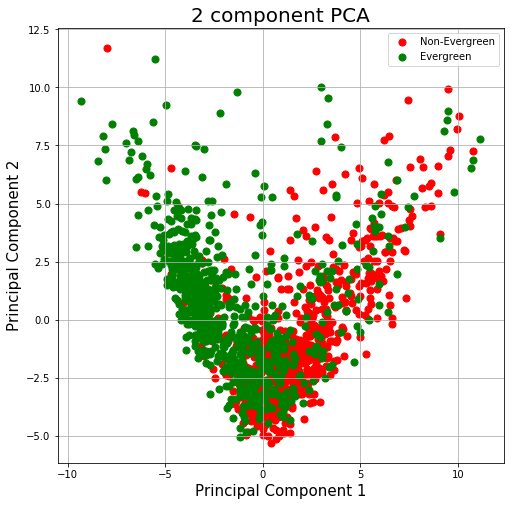

In [112]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['labels'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(['Non-Evergreen', 'Evergreen'])
ax.grid()

### t-SNE: t-Distributed Stochastic Neighbor Embedding

PCA is a linear dimensionality reduction technique. In contrast, t-SNE is a non-linear technique. [This](https://towardsdatascience.com/t-sne-python-example-1ded9953f26) medium article shows how to implement the technique for those who are interested. 

In [114]:
# import the necessary python packages
from sklearn.manifold import TSNE

In [115]:
tsne = TSNE(n_components = 2)
tsne_obj = tsne.fit_transform(x)
tsneDf = pd.DataFrame(data=tsne_obj, columns=['X', 'Y'])

In [116]:
finalDf = pd.concat([tsneDf, train_labels], axis=1)

**Let's plot this!**

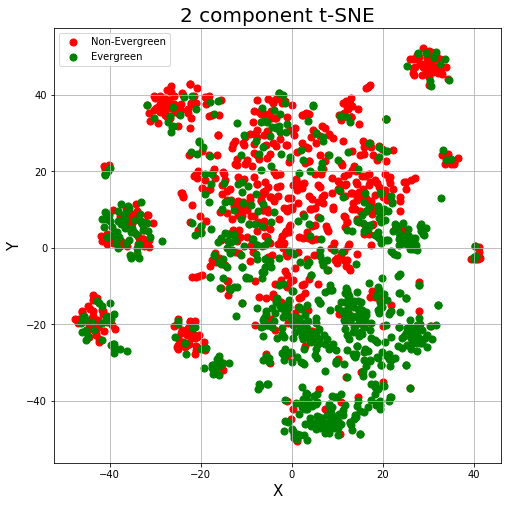

In [118]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('X', fontsize = 15)
ax.set_ylabel('Y', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['labels'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'X']
               , finalDf.loc[indicesToKeep, 'Y']
               , c = color
               , s = 50)
ax.legend(['Non-Evergreen', 'Evergreen'])
ax.grid()